## Exploring COVID Papers

This notebook uses terms data from CORD dataset, processed by Text Analytics for Health and stored in raw JSON format.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import gzip
import io

First, let's read all data on papers and corresponding mentions of medications:

In [2]:
df = pd.read_json('../data/PaperMedicationTerms.json.gz',compression='gzip')
df

,text,isNegated,title,publish_time,umls_id
0,FIPV-3CL,False,X-Ray structure and inhibition of the feline i...,2015-11-01,NaN
1,coronaviral,False,X-Ray structure and inhibition of the feline i...,2015-11-01,C0206419
2,flew,False,Potential for the International Spread of Midd...,2013-07-17,C0441659
3,Methylene blue dye,False,A reproducible ex vivo model for transanal min...,2014-01-01,NaN
4,Cortex-M4,False,A portable plantar pressure system: Specificat...,2020-01-01,NaN
...,...,...,...,...,...
202433,Acetate,False,Electronic Vape-associated Lung Injury: a Uniq...,2020-01-01,C0000975
202434,unadjuvanted RBD,False,Yeast-Expressed SARS-CoV Recombinant Receptor-...,2020-09-22,NaN
202435,AddaVax,False,Yeast-Expressed SARS-CoV Recombinant Receptor-...,2020-09-22,C3885324
202436,overlay aggregation method,False,Overcoming inefficiencies arising due to the i...,2020-10-03,NaN


Now let's remove those medications that do not have corresponding ontology id, and remove duplicate mentions of each medication in one paper. We will also limit the papers to the time period starting on January 1, 2020, and ending Ferburary 1, 2021.

In [3]:
clean_papers = df[(~df['umls_id'].isnull()) & (df['publish_time']>'2020-01-01') & (df['publish_time']<'2021-02-01')]\
               .drop_duplicates(subset=['title','umls_id'],keep='first')
clean_papers

,text,isNegated,title,publish_time,umls_id
7,enzalutamide,False,"Sex, androgens and regulation of pulmonary AR,...",2020-10-14,C3496793
10,Ecosystem,False,What happens when the money runs out? Forest o...,2020-08-17,C0162358
11,ticagrelor,False,Pharmacodynamic Comparison of Ticagrelor Monot...,2020-12-11,C1999375
14,thromboxane,False,Pharmacodynamic Comparison of Ticagrelor Monot...,2020-12-11,C0040061
18,Methylene blue,False,The Application of a Reduced Dye Used in Ortho...,2020-04-01,C0025746
...,...,...,...,...,...
202410,azithromycin,False,COVID-19: Behandlungsstrategien der deutschspr...,2020-08-18,C0052796
202411,anakinra,False,COVID-19: Behandlungsstrategien der deutschspr...,2020-08-18,C0245109
202412,tocilizumab,False,COVID-19: Behandlungsstrategien der deutschspr...,2020-08-18,C1609165
202413,remdesivir,False,COVID-19: Behandlungsstrategien der deutschspr...,2020-08-18,C4726677


Followed by the list of medications:

In [14]:
medindex = pd.read_json('../data/Medications.json')
medindex = medindex[~medindex['umls_id'].isnull()].drop_duplicates(subset='umls_id',keep='first').set_index('umls_id')
medindex

,text
umls_id,
C0206419,coronaviral
C0441659,flew
C0556962,MHz
C3496793,enzalutamide
C1880266,defence
...,...
C0023043,large T antigen
C1869251,GP78
C3242561,shelter community


Let's find out top medications by number of mentions:

In [15]:
meds = clean_papers.groupby('umls_id').agg({ 'title' : 'count', 'isNegated' : sum })\
       .rename(columns={'title' : 'mentions', 'isNegated' : 'negative'})\
       .sort_values(by='mentions',ascending=False)\
       .merge(medindex,on='umls_id').rename(columns={ 'text' : 'name' })
meds.head(15)

,mentions,negative,name
umls_id,,,
C0020336,1563,33,hydroxychloroquine
C4726677,854,8,remdesivir
C0008269,698,12,chloroquine
C0034386,648,12,quarantine
C1609165,593,10,Tocilizumab
C0674432,578,6,lopinavir
C0292818,552,7,ritonavir
C0052796,547,38,azithromycin
C0011777,286,1,dexamethasone


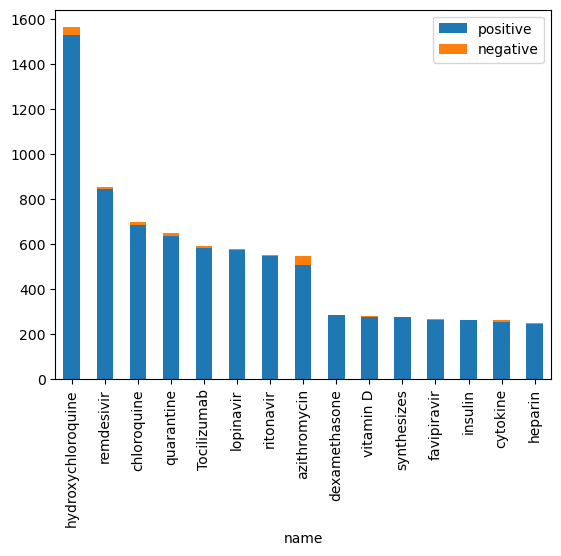

In [16]:
meds['positive'] = meds['mentions']-meds['negative']
meds.iloc[:15].set_index('name')[['positive','negative']].plot(kind='bar',rot=90,stacked=True)
plt.show()

In [17]:
topmeds = {
    'C0020336' : 'hydroxychloroquine',
    'C4726677' : 'remdesivir',
    'C0008269' : 'chloroquine',
    'C1609165' : 'tocilizumab',
    'C0674432' : 'lopinavir',
    'C0292818' : 'ritonavir',
    'C0052796' : 'azithromycin',
    'C0011777' : 'dexamethasone',
    'C0042866' : 'vitamin D',
    'C1138226' : 'favipiravir',
    'C0021641' : 'insulin',
    'C0019134' : 'heparin'
}

In [18]:
clean_papers['month'] = clean_papers['publish_time'].astype('datetime64[M]')

imeds = clean_papers[clean_papers['umls_id'].apply(lambda x: x in topmeds.keys())].copy()
imeds['name'] = imeds['umls_id'].apply(lambda x: topmeds[x])

def positive_count(x):
    return x.value_counts()

def negative_count(x):
    return x.value_counts()
    c = x.value_counts()
    return 0 if len(c)<2 else -c[1]

medhist = imeds.groupby(['month','name']).agg({'text' : 'count', 'isNegated' : 'sum' }).rename(columns={'text' : 'mentions', 'isNegated' : 'negative' })
medhist['positive'] = medhist['mentions']-medhist['negative']
medhist

mentions  negative  positive
month      name                                            
2020-01-01 azithromycin               2         0         2
           chloroquine                1         0         1
           heparin                    2         0         2
           hydroxychloroquine         1         0         1
           lopinavir                  4         0         4
...                                 ...       ...       ...
2021-01-01 lopinavir                 38         0        38
           remdesivir                74         0        74
           ritonavir                 37         0        37
           tocilizumab               46         1        45
           vitamin D                 29         1        28

[149 rows x 3 columns]

In [19]:
mnthlymentions = clean_papers.groupby('month').agg({'text' : 'count' }).rename(columns={'text' : 'mcount'})
mnthlymentions

,mcount
month,
2020-01-01,436
2020-02-01,546
2020-03-01,999
2020-04-01,2232
2020-05-01,3753
2020-06-01,3962
2020-07-01,4544
2020-08-01,4780
2020-09-01,5248


In [20]:
medhist['relmentions'] = 0.0
for d in mnthlymentions.index:
    medhist.loc[d]['relmentions'] = medhist.loc[d,'mentions'] / mnthlymentions.loc[d,'mcount']
medhist

<ipython-input-20-14d61156de67>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  medhist.loc[d]['relmentions'] = medhist.loc[d,'mentions'] / mnthlymentions.loc[d,'mcount']


mentions  negative  positive  relmentions
month      name                                                         
2020-01-01 azithromycin               2         0         2     0.004587
           chloroquine                1         0         1     0.002294
           heparin                    2         0         2     0.004587
           hydroxychloroquine         1         0         1     0.002294
           lopinavir                  4         0         4     0.009174
...                                 ...       ...       ...          ...
2021-01-01 lopinavir                 38         0        38     0.010728
           remdesivir                74         0        74     0.020892
           ritonavir                 37         0        37     0.010446
           tocilizumab               46         1        45     0.012987
           vitamin D                 29         1        28     0.008187

[149 rows x 4 columns]

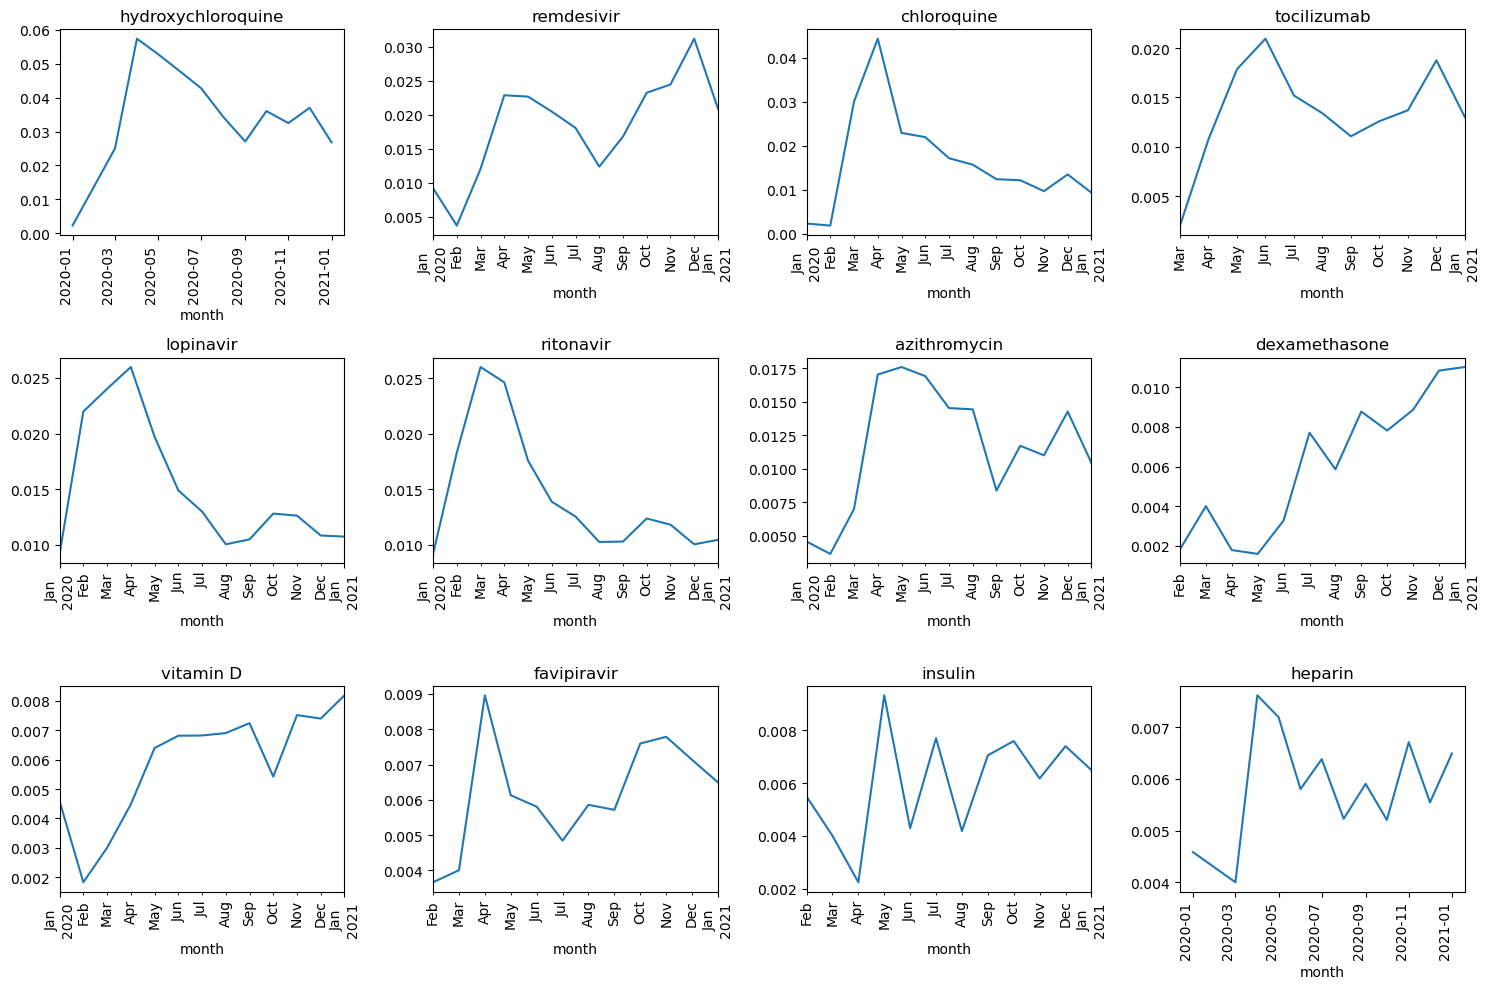

In [21]:
medh = medhist.reset_index()
fig,ax = plt.subplots(3,4,figsize=(15,10))
for i,n in enumerate(topmeds.keys()):
    medh[medh['name']==topmeds[n]].set_index('month')['relmentions'].plot(title=topmeds[n],ax=ax[i//4,i%4],rot=90)
fig.tight_layout()
plt.show()